### Test Data

In [1]:
import datetime
import pandas as pd
import numpy as np
import xml.etree.cElementTree as ET
from xml.etree.ElementTree import fromstring, ElementTree
import sys
import os
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker


df_demo = pd.DataFrame()

SQLitePath = "D:/SQLiteDB/SQLiteStudio/AT.db"
engine = create_engine('sqlite:///' + SQLitePath)#建立一個連接DB的引擎(windows)

#df_panel = pd.read_sql_table('panel', engine)
# by 時間撈取資料
df_panel = pd.read_sql("SELECT * FROM panel_L6B WHERE datetime(SHEET_ETIME) >=  datetime('now','localtime', '-60 day') ", 
                    engine.connect())
df_panel['SHEET_STIME'] = pd.to_datetime(df_panel['SHEET_STIME'])
df_panel['INS_DATE'] = df_panel['SHEET_STIME'].dt.date
df_panel['INS_WEEK'] = df_panel['SHEET_STIME'].dt.strftime('%YW%U')
df_panel['CK'] = 1
key_list = ['OP_NO', 'LOT_ID', 'SHEET_ID', 'PANEL_ID', 'SHEET_STIME', 'INS_DATE', 'INS_WEEK', 'QUALITY_JUDGE', 'REASON1_JUDGE', 'REASON2_JUDGE', 'PANEL_CNT', 'CK']
panel_df = df_panel[key_list]
panel_df['OP_NO'] = panel_df['OP_NO'].astype(int)
panel_df['PANEL_CNT'] = panel_df['PANEL_CNT'].astype(int)
panel_df = panel_df[panel_df['OP_NO']>2000][key_list]
panel_df.loc[panel_df['QUALITY_JUDGE'].isna(), 'QUALITY_JUDGE'] = 'NaN'
panel_yield = panel_df.pivot_table(values='CK', index=['OP_NO', 'LOT_ID', 'SHEET_ID', 'SHEET_STIME', 'INS_DATE', 'INS_WEEK', 'PANEL_CNT'], columns=['QUALITY_JUDGE'], aggfunc='count', fill_value=0).reset_index()


if ('G' in panel_yield.columns.tolist()):
    panel_tmp = panel_yield['G'].tolist()
    panel_yield['G'] = 0
    panel_yield['G'] = panel_tmp
else:
    panel_yield['G'] = 0
if ('R' in panel_yield.columns.tolist()):
    panel_tmp = panel_yield['R'].tolist()
    panel_yield['R'] = 0
    panel_yield['R'] = panel_tmp
else:
    panel_yield['R'] = 0
if ('N' in panel_yield.columns.tolist()):
    panel_tmp = panel_yield['N'].tolist()
    panel_yield['N'] = 0
    panel_yield['N'] = panel_tmp
else:
    panel_yield['N'] = 0
if ('S' in panel_yield.columns.tolist()):
    panel_tmp = panel_yield['S'].tolist()
    panel_yield['S'] = 0
    panel_yield['S'] = panel_tmp
else:
    panel_yield['S'] = 0

panel_yield['JUDGE_CNT'] = panel_yield['G'] + panel_yield['N'] + panel_yield['R'] + panel_yield['S']



#F/S ='1';#B/S='2'
product_type = '1' 
#EE#EB
model_type = 'EE'




panel_yield = panel_yield[panel_yield['LOT_ID'].astype(str).str[2] == product_type ] 
panel_yield['yield'] = panel_yield['G']/ (panel_yield['G'] + panel_yield['N'])
df_demo['A'] = panel_yield['yield']
panel_yield

,OP_NO,LOT_ID,SHEET_ID,SHEET_STIME,INS_DATE,INS_WEEK,PANEL_CNT,G,R,N,S,JUDGE_CNT,yield
QUALITY_JUDGE,,,,,,,,,,,,,


In [5]:
import pandas as pd
panel_yield = pd.read_csv('panel_yield.csv', index_col=0)
df_demo['A'] = panel_yield['yield']

### moving avg and std

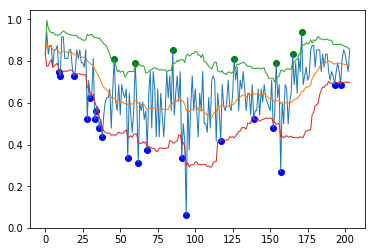

In [6]:
# 移動視窗
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics

def moving_avg(data, long_window=21, short_window=7, std_times=3, plot = 'short'):
    df = pd.DataFrame()
    mean_long = []
    mean_short = []
    std_long = []
    std_short = []

    # imputation of mean & std value
    for i in range(len(data)):
        if i < long_window-1:
            mean_long.append(data[0:(i+1)].mean())
            std_long.append(data[0:(i+1)].std())

        if i < short_window-1:
            mean_short.append(data[0:(i+1)].mean())
            std_short.append(data[0:(i+1)].std())

    # mean value 
    long_window_mean = data.rolling(long_window).mean().tolist()
    long_window_mean[:long_window-1] = mean_long
    short_window_mean = data.rolling(short_window).mean().tolist()
    short_window_mean[:short_window-1] = mean_short
    
    # std value
    long_window_std = data.rolling(long_window).std().tolist()
    long_window_std[:long_window-1] = std_long
    long_window_std[0] = 0
    short_window_std = data.rolling(short_window).std().tolist()
    short_window_std[:short_window-1] = std_short
    short_window_std[0] = 0
    
    df['long_window_mean'] = long_window_mean
    df['short_window_mean'] = short_window_mean
    df['long_window_std'] = long_window_std
    df['short_window_std'] = short_window_std
    
    # UCL&LCL
    df['short_upper'] = df.short_window_mean + std_times*df.short_window_std
    df['short_lower'] = df.short_window_mean - std_times*df.short_window_std
    df['long_upper'] = df.long_window_mean + std_times*df.long_window_std
    df['long_lower'] = df.long_window_mean - std_times*df.long_window_std

    # out spec counting(long Window)
    array_value = np.array(data.tolist())
    array_long_over = np.array(df.long_upper.tolist())
    array_long_under =np.array(df.long_lower.tolist())
    subtracted_long_over = np.subtract(array_long_over, array_value)
    subtracted_long_under = np.subtract(array_long_under, array_value)
    long_over_list = list(subtracted_long_over)
    long_under_list = list(subtracted_long_under)
    df['long_over'] = [data.tolist()[long_over_list.index(i)] if i<0 else np.nan for i in long_over_list]
    df['long_over'][0] = np.nan
    df['long_under'] = [data.tolist()[long_under_list.index(i)] if i>0 else np.nan for i in long_under_list]
    df['long_under'][0] = np.nan
    
    # out spec counting(Short Window)
    array_short_over = np.array(df.short_upper.tolist())
    array_short_under =np.array(df.short_lower.tolist())
    subtracted_short_over = np.subtract(array_short_over, array_value)
    subtracted_short_under = np.subtract(array_short_under, array_value)
    short_over_list = list(subtracted_short_over)
    short_under_list = list(subtracted_short_under)
    df['short_over'] = [data.tolist()[short_over_list.index(i)] if i<0 else np.nan for i in short_over_list]
    df['short_over'][0] = np.nan
    df['short_under'] = [data.tolist()[short_under_list.index(i)] if i>0 else np.nan for i in short_under_list]
    df['short_under'][0] = np.nan
    
    
    # show plot
    if plot == 'long':
        plt.plot(data,linewidth = '1')
        plt.plot(df['long_window_mean'],linewidth = '1')
        plt.plot(df['long_upper'],linewidth = '1')
        plt.plot(df['long_lower'],linewidth = '1')
        plt.scatter(y= df['long_under'].tolist(), x = df.index.tolist(),color="blue")
        plt.scatter(y= df['long_over'].tolist(), x = df.index.tolist(),color="green")
    
    if plot == 'short':
        plt.plot(data,linewidth = '1')
        plt.plot(df['short_window_mean'],linewidth = '1')
        plt.plot(df['short_upper'],linewidth = '1')
        plt.plot(df['short_lower'],linewidth = '1')
        plt.scatter(y= df['short_under'].tolist(), x = df.index.tolist(),color="blue")
        plt.scatter(y= df['short_over'].tolist(), x = df.index.tolist(),color="green")
    return df

df = moving_avg(df_demo['A'], long_window=21, short_window=7, std_times=1.5, plot = 'long')
df.to_csv('moving_avg.csv')

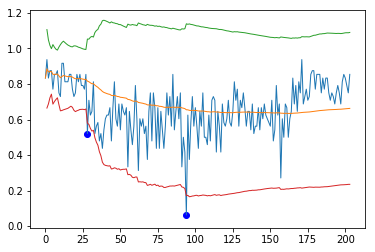

In [7]:
# 加總
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
x = df_demo.A.tolist()
df = pd.DataFrame()

mean_current = []
std_current = []
std_upper = []
std_lower = []

for i in range(len(x)):
    mean_current.append(df_demo['A'][0:(i+1)].mean())
    std_current.append(df_demo['A'][0:(i+1)].std())
    std_upper.append(mean_current[-1] + 3*std_current[-1])
    std_lower.append(mean_current[-1] - 3*std_current[-1])

array_value = np.array(x)
array_over = np.array(std_upper)
array_under =np.array(std_lower)
subtracted_over = np.subtract(array_over, array_value)
subtracted_under = np.subtract(array_under, array_value)
over_list = list(subtracted_over)
under_list = list(subtracted_under)

# df['EWMA'] = df['A'].ewm(alpha=0.5,adjust=False).mean()
df['over'] = [x[over_list.index(i)] if i<0 else np.nan for i in over_list]
df['under'] = [x[under_list.index(i)] if i>0 else np.nan for i in under_list]
df['mean'] = mean_current
df['upper'] = std_upper
df['lower'] = std_lower

df['over'][0] = np.nan
df['under'][0] = np.nan

plt.plot(df_demo['A'],linewidth = '1')
plt.plot(df['mean'],linewidth = '1')
plt.plot(df['upper'],linewidth = '1')
plt.plot(df['lower'],linewidth = '1')
# plt.plot(df['EWMA'],linewidth = '1')
plt.scatter(y= df['under'].tolist(), x = df.index.tolist(),color="blue")
plt.scatter(y= df['over'].tolist(), x = df.index.tolist(),color="green")


### EWMA

,data,ewm_value,long_center_line,short_center_line,long_window_std,short_window_std,short_UCL,short_LCL,long_UCL,long_LCL,long_ewma_over,long_ewma_under,short_ewma_over,short_ewma_under
0,0.833333,0.833333,0.833333,0.833333,0.000000,0.000000,0.833333,0.833333,0.833333,0.833333,NaN,NaN,NaN,NaN
1,0.937500,0.843750,0.885417,0.885417,0.073657,0.073657,0.907514,0.863320,0.907514,0.863320,0.937500,NaN,0.937500,NaN
2,0.833333,0.842708,0.868056,0.868056,0.060141,0.060141,0.892329,0.843782,0.892329,0.843782,NaN,0.833333,NaN,0.833333
3,0.875000,0.845937,0.869792,0.869792,0.049227,0.049227,0.892983,0.846600,0.892983,0.846600,NaN,NaN,NaN,NaN
4,0.875000,0.848844,0.870833,0.870833,0.042696,0.042696,0.893010,0.848657,0.893010,0.848657,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.854167,0.770968,0.785714,0.761905,0.058978,0.062334,0.804806,0.719003,0.826306,0.745123,0.854167,NaN,0.854167,NaN
200,0.833333,0.777204,0.783730,0.782738,0.056472,0.057505,0.822316,0.743160,0.822597,0.744864,0.833333,NaN,0.833333,NaN
201,0.791667,0.778650,0.784722,0.788690,0.056417,0.055679,0.827012,0.750369,0.823551,0.745893,NaN,NaN,NaN,NaN
202,0.750000,0.775785,0.779762,0.782738,0.054554,0.057505,0.822316,0.743160,0.817309,0.742215,NaN,NaN,NaN,NaN


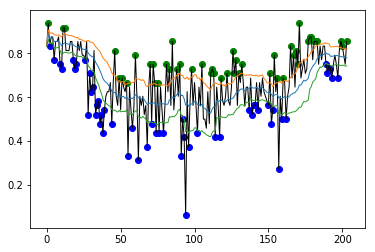

In [8]:
def ewma(data, L=3, a=0.1, long_window=21, short_window=7, plot = "short"):
    df = pd.DataFrame()
    df['data'] = data
    ewm = []
    
    # ewma value
    for i in range(len(data.tolist())):
        if i == 0:
            ewm.append(data[i])
            continue
        tmp = a*data[i] + (1-a)*ewm[i-1]
        ewm.append(tmp)
    df['ewm_value'] = ewm
    
    mean_long = []
    mean_short = []
    std_long = []
    std_short = []
    long_center_line = []
    short_center_line = []

    # imputation of mean & std value
    for i in range(len(data)):
        if i < long_window-1:
            mean_long.append(data[0:(i+1)].mean())
            std_long.append(data[0:(i+1)].std())

        if i < short_window-1:
            mean_short.append(data[0:(i+1)].mean())
            std_short.append(data[0:(i+1)].std())
    
    # center_line
    long_center_line = data.rolling(long_window).mean().tolist()
    long_center_line[:long_window-1] = mean_long
    df['long_center_line'] = long_center_line
    short_center_line = data.rolling(short_window).mean().tolist()
    short_center_line[:short_window-1] = mean_short
    df['short_center_line'] = short_center_line
    
    # std value
    long_window_std = data.rolling(long_window).std().tolist()
    long_window_std[:long_window-1] = std_long
    long_window_std[0] = 0
    df['long_window_std'] = long_window_std
    short_window_std = data.rolling(short_window).std().tolist()
    short_window_std[:short_window-1] = std_short
    short_window_std[0] = 0
    df['short_window_std'] = short_window_std
    
    # UCL&LCL(short)
    tmp_short_ucl = []
    tmp_short_lcl = []
    for i in range(len(data)):
        tmp_short_ucl.append(df.short_center_line.tolist()[i] + L*df.short_window_std.tolist()[i]*(((a/(2-a)*(1-(1-a)**(2*i))))**0.5))
        tmp_short_lcl.append(df.short_center_line.tolist()[i] - L*df.short_window_std.tolist()[i]*(((a/(2-a)*(1-(1-a)**(2*i))))**0.5))
    
    df['short_UCL'] = tmp_short_ucl
    df['short_LCL'] = tmp_short_lcl
     
    # UCL&LCL(long)
    tmp_long_ucl = []
    tmp_long_lcl = []
    for i in range(len(data)):
        tmp_long_ucl.append(df.long_center_line.tolist()[i] + L*df.long_window_std.tolist()[i]*(((a/(2-a)*(1-(1-a)**(2*i))))**0.5))
        tmp_long_lcl.append(df.long_center_line.tolist()[i] - L*df.long_window_std.tolist()[i]*(((a/(2-a)*(1-(1-a)**(2*i))))**0.5))
    
    df['long_UCL'] = tmp_long_ucl
    df['long_LCL'] = tmp_long_lcl

    # out spec counting
    df['long_ewma_over'] = [df.data.tolist()[x] if (df.data.tolist()[x] - df.long_UCL.tolist()[x]) >= 0 else np.nan for x in range(len(df.data.tolist()))]
    df['long_ewma_over'][0] = np.nan
    df['long_ewma_under'] = [df.data.tolist()[x] if (df.data.tolist()[x] - df.long_LCL.tolist()[x]) <= 0 else np.nan for x in range(len(df.data.tolist()))]
    df['long_ewma_under'][0] = np.nan
    df['short_ewma_over'] = [df.data.tolist()[x] if (df.data.tolist()[x] - df.short_UCL.tolist()[x]) >= 0 else np.nan for x in range(len(df.data.tolist()))]
    df['short_ewma_over'][0] = np.nan
    df['short_ewma_under'] = [df.data.tolist()[x] if (df.data.tolist()[x] - df.short_LCL.tolist()[x]) <= 0 else np.nan for x in range(len(df.data.tolist()))]
    df['short_ewma_under'][0] = np.nan
    

    
    
     # show plot
    if plot == 'long':
        plt.plot(data,linewidth = '1', color='black')
#         plt.plot(df['ewm_value'],linewidth = '1')
        plt.plot(df['long_center_line'],linewidth = '1')
        plt.plot(df['long_UCL'],linewidth = '1')
        plt.plot(df['long_LCL'],linewidth = '1')
        plt.scatter(y= df['long_ewma_under'].tolist(), x = df.index.tolist(),color="blue")
        plt.scatter(y= df['long_ewma_over'].tolist(), x = df.index.tolist(),color="green")
    
    if plot == 'short':
        plt.plot(data,linewidth = '1', color='black')
#         plt.plot(df['ewm_value'],linewidth = '1')
        plt.plot(df['short_center_line'],linewidth = '1')
        plt.plot(df['short_UCL'],linewidth = '1')
        plt.plot(df['short_LCL'],linewidth = '1')
        plt.scatter(y= df['short_ewma_under'].tolist(), x = df.index.tolist(),color="blue")
        plt.scatter(y= df['short_ewma_over'].tolist(), x = df.index.tolist(),color="green")

    
    return df

df = ewma(df_demo['A'], L=3, a=0.1, long_window=21, short_window=7, plot = "long")
df.to_csv('ewm.csv')
df

### IQR

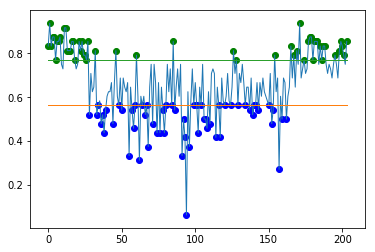

In [9]:
df = pd.DataFrame()
df['data'] = df_demo.A.tolist()
Q1 = np.quantile(df_demo.A.tolist(), 0.25, axis=0)
Q3 = np.quantile(df_demo.A.tolist(), 0.75, axis=0)
IQR = Q3-Q1

df['Q1'] = [Q1] * len(df_demo.A.tolist())
df['Q3'] = [Q3] * len(df_demo.A.tolist())

df['over_Q3'] = [df_demo.A.tolist()[x] if (df_demo.A.tolist()[x] - Q3) >= 0 else np.nan for x in range(len(df_demo.A.tolist()))]
df['under_Q1'] = [df_demo.A.tolist()[x] if (df_demo.A.tolist()[x] - Q1) <= 0 else np.nan for x in range(len(df_demo.A.tolist()))]



plt.plot(df_demo['A'],linewidth = '1')
plt.plot(df['Q1'],linewidth = '1')
plt.plot(df['Q3'],linewidth = '1')
plt.scatter(y= df['under_Q1'].tolist(), x = df.index.tolist(),color="blue")
plt.scatter(y= df['over_Q3'].tolist(), x = df.index.tolist(),color="green")

df.to_csv('IQR.csv')